In [3]:
# 1. Загрузка и предварительный анализ данных
# -------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Улучшение отображения графиков
plt.style.use('seaborn-v0_8-whitegrid') # Используем стиль seaborn
sns.set(style='whitegrid', palette='muted', font_scale=1.2) # Настройки seaborn
plt.rcParams['figure.figsize'] = [18, 8] # Увеличим размер графиков по умолчанию
plt.rcParams['axes.titlesize'] = 16 # Размер заголовка
plt.rcParams['axes.labelsize'] = 14 # Размер подписей осей
plt.rcParams['xtick.labelsize'] = 12 # Размер подписей тиков по X
plt.rcParams['ytick.labelsize'] = 12 # Размер подписей тиков по Y
plt.rcParams['legend.fontsize'] = 12 # Размер легенды

# Загрузка данных
df = pd.read_csv('realAWSCloudwatch/elb_request_count_8c0756.csv')

# Просмотр первых строк датасета
print("\nПервые строки датасета:")
print(df.head())

# Информация о структуре датасета
print("\nСтруктура датасета:")
print(df.info())

# Статистический анализ
print("\nСтатистика датасета:")
print(df.describe())

# Проверка на пропуски в данных
print("\nПроверка на пропуски в данных:")
print(df.isnull().sum())

# Преобразование столбца времени в datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Проверим наличие дубликатов по индексу (времени)
print(f"\nНаличие дубликатов во временном индексе: {df.index.duplicated().any()}")

# Проверим монотонность индекса
if df.index.is_monotonic_increasing:
    print("Временной индекс монотонно возрастает.")
else:
    print("Временной индекс НЕ монотонно возрастает. Сортировка...")
    df.sort_index(inplace=True)


Первые строки датасета:
             timestamp  value
0  2014-04-10 00:04:00   94.0
1  2014-04-10 00:09:00   56.0
2  2014-04-10 00:14:00  187.0
3  2014-04-10 00:19:00   95.0
4  2014-04-10 00:24:00   51.0

Структура датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None

Статистика датасета:
             value
count  4032.000000
mean     61.837054
std      56.664703
min       1.000000
25%      15.000000
50%      48.000000
75%      89.000000
max     656.000000

Проверка на пропуски в данных:
timestamp    0
value        0
dtype: int64

Наличие дубликатов во временном индексе: False
Временной индекс монотонно возрастает.


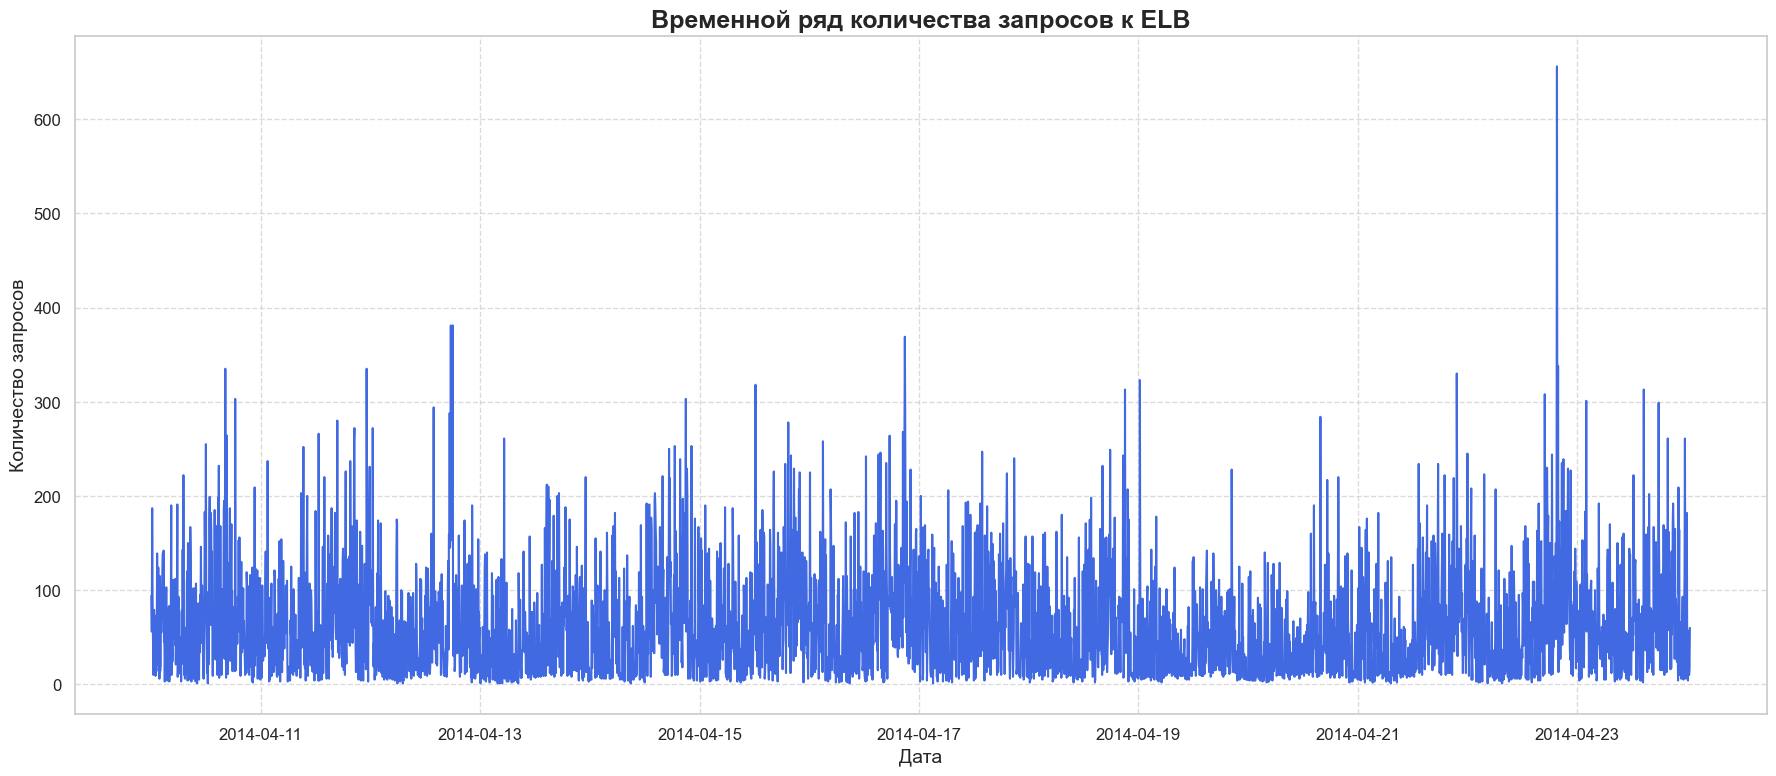

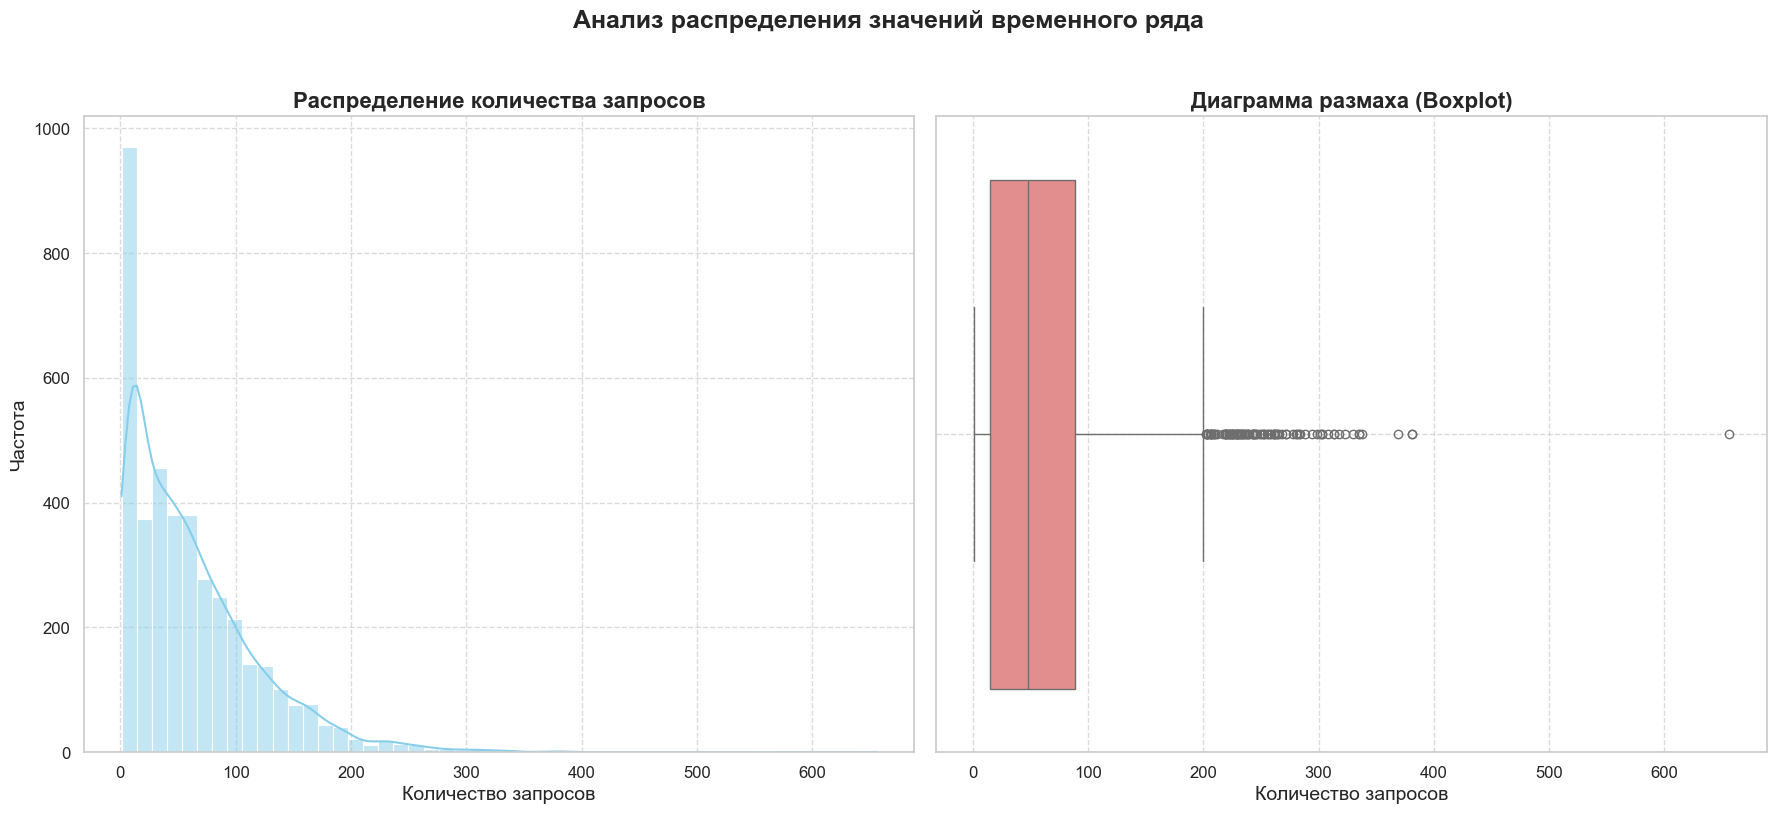

C:\Users\ivglu\AppData\Local\Temp\ipykernel_24832\2912400245.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='value', data=df, palette='viridis')


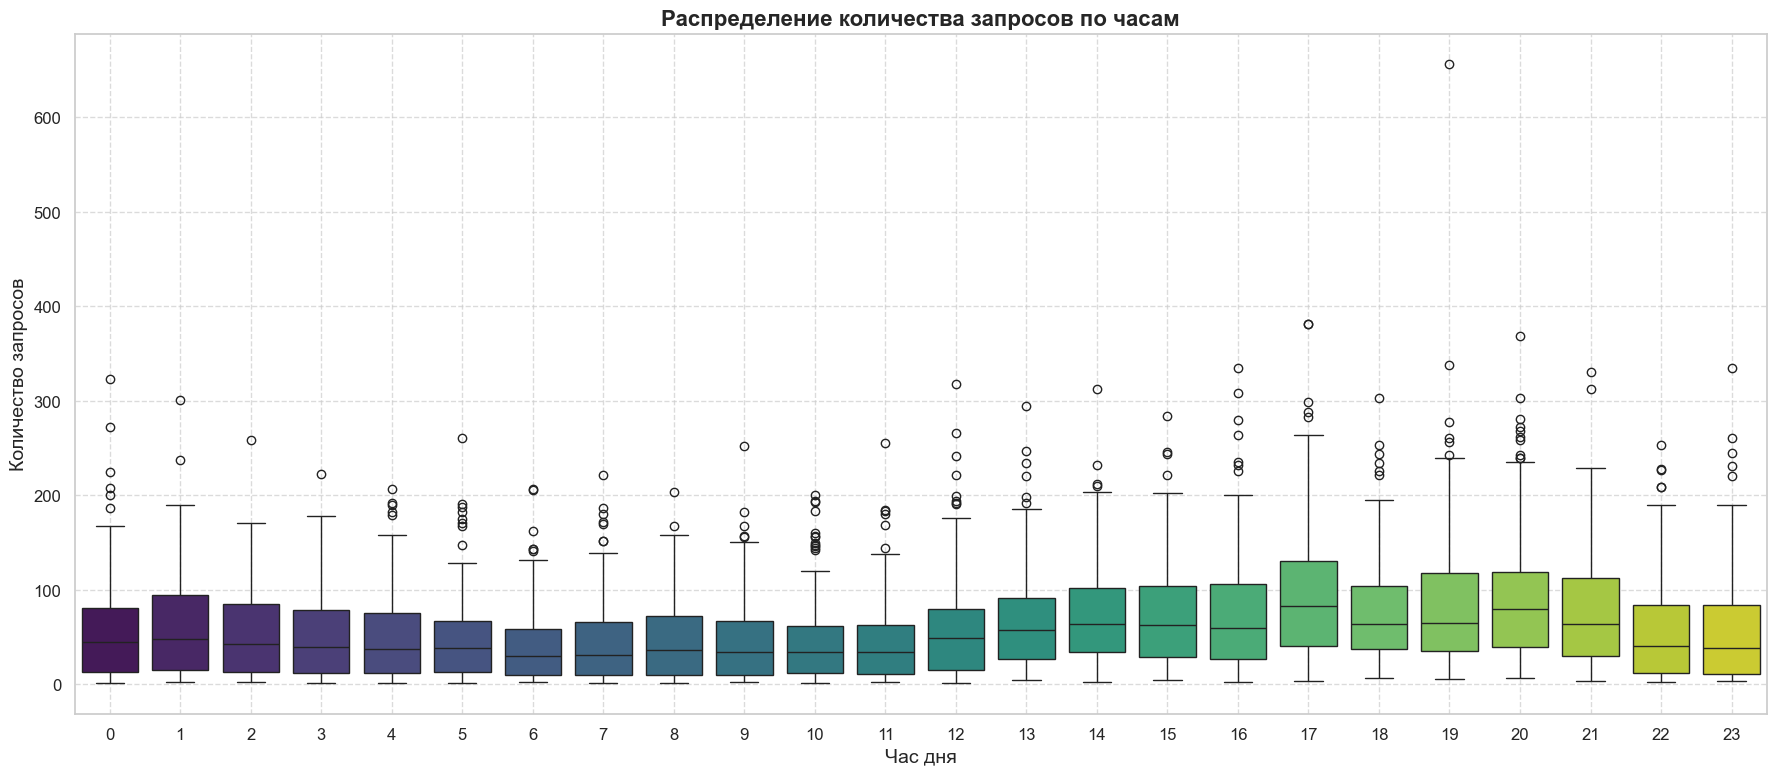

C:\Users\ivglu\AppData\Local\Temp\ipykernel_24832\2912400245.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dayofweek', y='value', data=df, palette='magma')


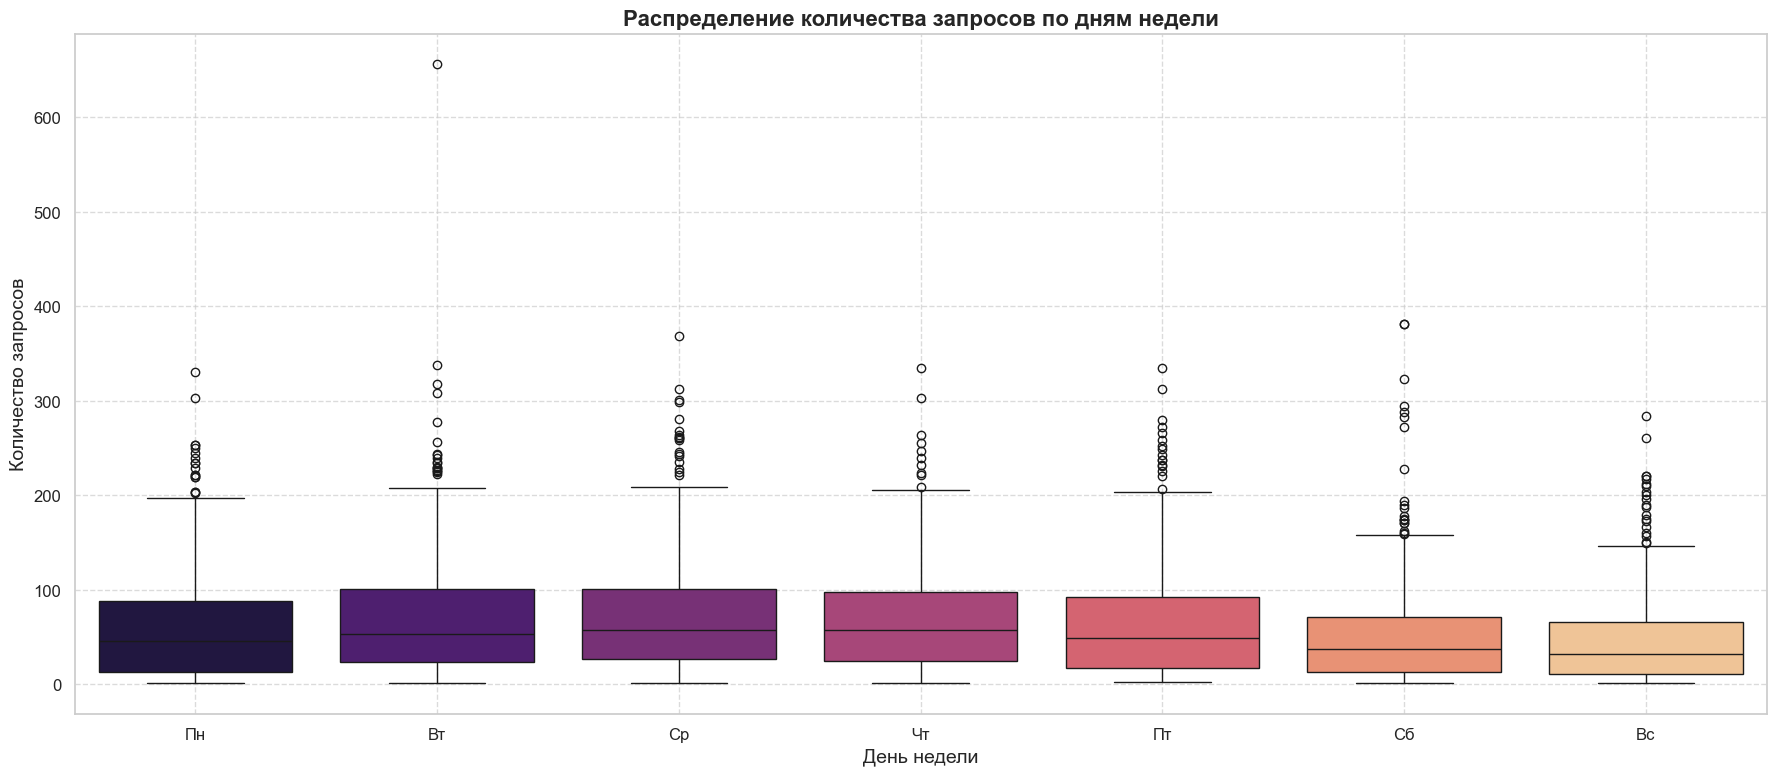

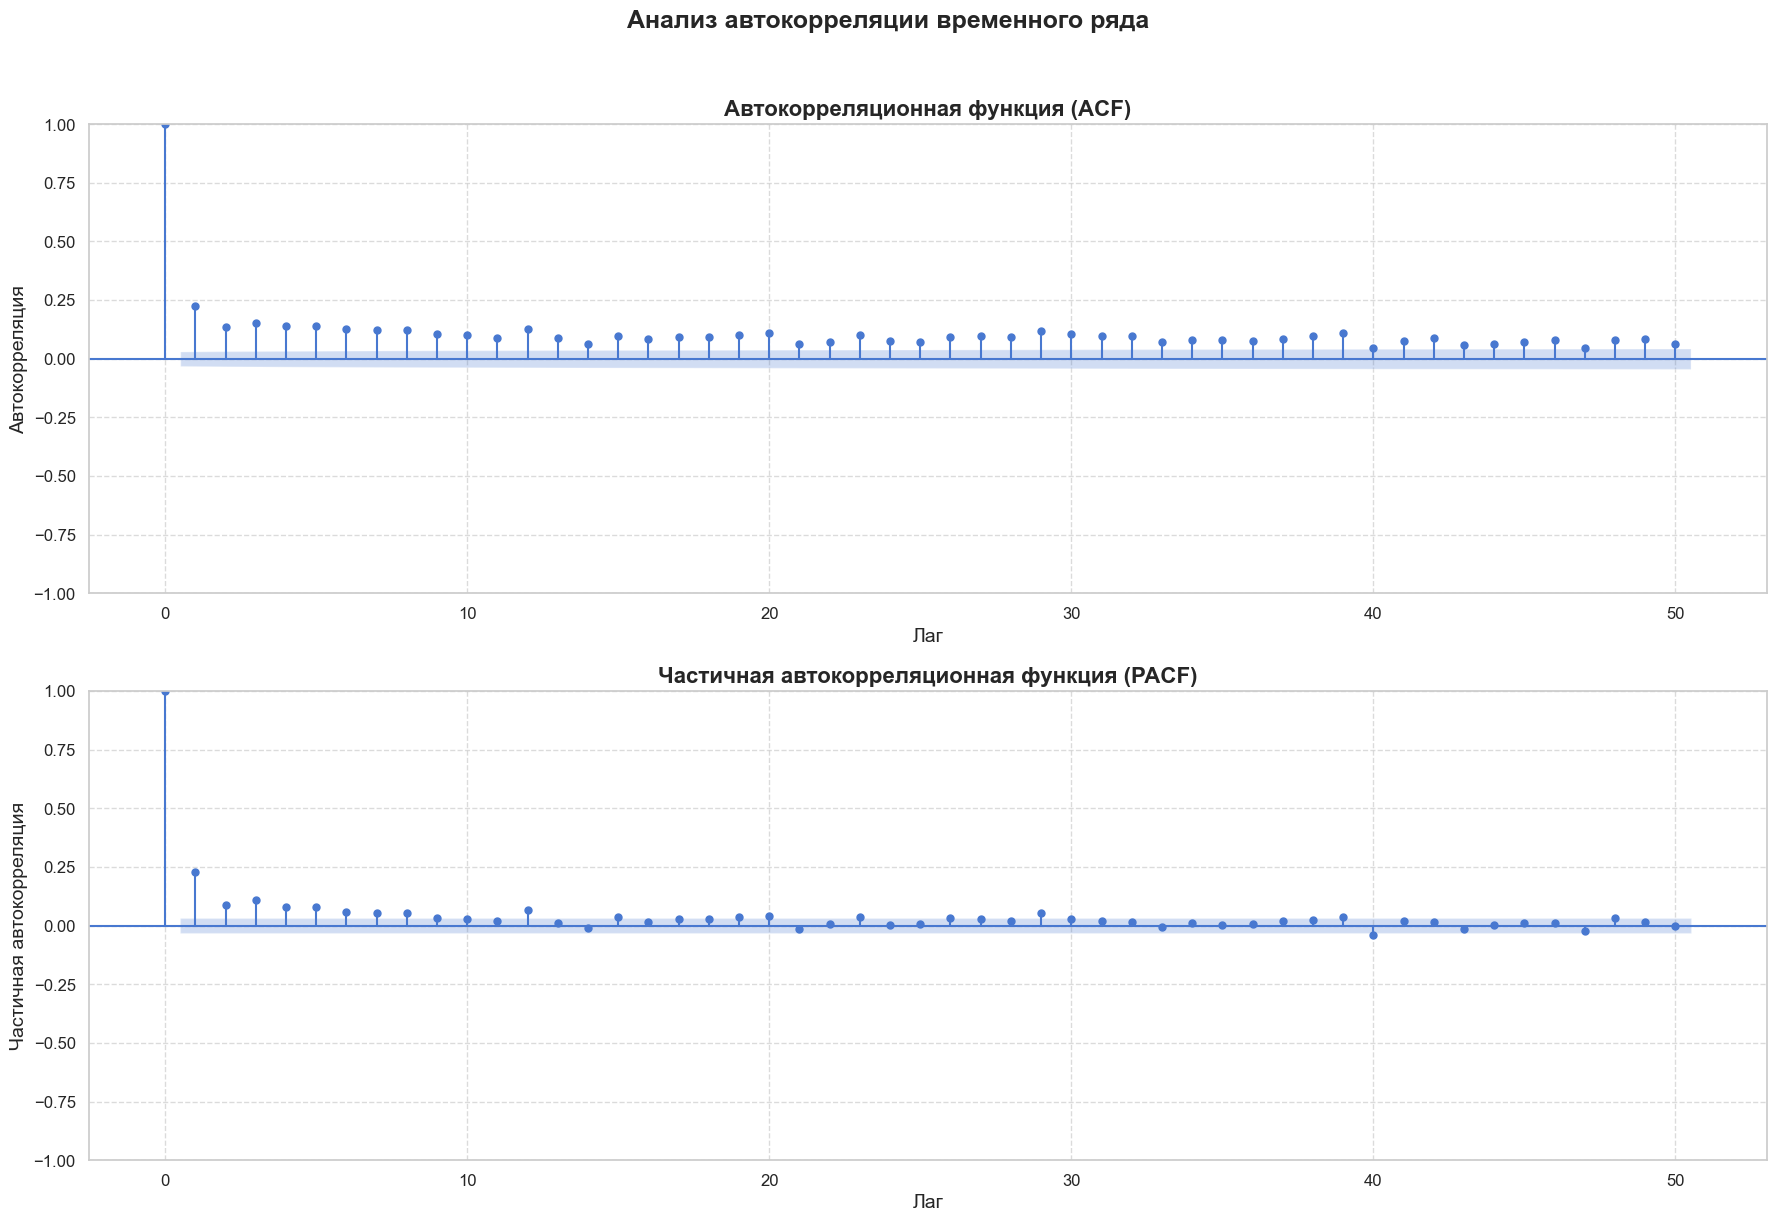

In [4]:
# 2. Разведочный анализ данных (EDA) - Улучшенная визуализация
# ----------------------------------------------------------

# Построение временного ряда
plt.figure(figsize=(18, 8)) # Явно задаем размер
plt.plot(df.index, df['value'], color='royalblue', linewidth=1.5)
plt.title('Временной ряд количества запросов к ELB', fontsize=18, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество запросов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Анализ распределения данных
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.histplot(df['value'], kde=True, color='skyblue', bins=50)
plt.title('Распределение количества запросов', fontsize=16, fontweight='bold')
plt.xlabel('Количество запросов', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.boxplot(x=df['value'], color='lightcoral')
plt.title('Диаграмма размаха (Boxplot)', fontsize=16, fontweight='bold')
plt.xlabel('Количество запросов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Анализ распределения значений временного ряда', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Анализ временных паттернов
# Создание дополнительных временных признаков
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Анализ почасовой активности
plt.figure(figsize=(18, 8))
sns.boxplot(x='hour', y='value', data=df, palette='viridis')
plt.title('Распределение количества запросов по часам', fontsize=16, fontweight='bold')
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество запросов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Анализ по дням недели
plt.figure(figsize=(18, 8))
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
sns.boxplot(x='dayofweek', y='value', data=df, palette='magma')
plt.title('Распределение количества запросов по дням недели', fontsize=16, fontweight='bold')
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество запросов', fontsize=14)
plt.xticks(ticks=range(7), labels=day_names)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Анализ автокорреляции

fig, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['value'], lags=50, ax=ax[0])
ax[0].set_title('Автокорреляционная функция (ACF)', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Лаг', fontsize=14)
ax[0].set_ylabel('Автокорреляция', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.7)

plot_pacf(df['value'], lags=50, ax=ax[1])
ax[1].set_title('Частичная автокорреляционная функция (PACF)', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Лаг', fontsize=14)
ax[1].set_ylabel('Частичная автокорреляция', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Анализ автокорреляции временного ряда', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# 3. Подготовка данных для модели
# -----------------------------

# Функция для создания временных окон
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Масштабирование данных
scaler = MinMaxScaler(feature_range=(-1, 1)) # Оставляем -1, 1 для LSTM
# Берем только столбец 'value', т.к. временные признаки были для EDA
data_scaled = scaler.fit_transform(df[['value']])

# Определение длины последовательности
seq_length = 24  # Используем 24 точки (2 часа, если 5 мин интервал) для прогнозирования

# Создание последовательностей
X, y = create_sequences(data_scaled, seq_length)

# Разделение данных на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Размер обучающей выборки X: {X_train.shape}, y: {y_train.shape}")
print(f"Размер тестовой выборки X: {X_test.shape}, y: {y_test.shape}")

# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Создание датасетов и даталоадеров
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Перемешиваем для обучения
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Не перемешиваем для теста

Размер обучающей выборки X: (3206, 24, 1), y: (3206, 1)
Размер тестовой выборки X: (802, 24, 1), y: (802, 1)


In [6]:
# 4. Определение модели LSTM с PyTorch
# -----------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=2, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # LSTM слой с Dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Полносвязный слой
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Инициализация скрытого состояния
        # Проверка доступности GPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)

        # Перемещаем входные данные на то же устройство, что и скрытые состояния
        x = x.to(device)

        # Прямой проход через LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach())) # .detach() чтобы не учитывать инициализацию в графе вычислений

        # Берем вывод последнего временного шага
        out = self.linear(out[:, -1, :])
        return out

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Обучение будет производиться на устройстве: {device}")

# Создание экземпляра модели и перемещение на устройство
model = LSTMModel(input_size=1, hidden_layer_size=100, output_size=1, num_layers=2, dropout_prob=0.2)
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# (Опционально) Планировщик скорости обучения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

Обучение будет производиться на устройстве: cuda


c:\Users\ivglu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Эпоха 5/50, Потери на обучении: 0.0284, Потери на тесте: 0.0322
Эпоха 10/50, Потери на обучении: 0.0281, Потери на тесте: 0.0315
Эпоха 15/50, Потери на обучении: 0.0277, Потери на тесте: 0.0314
Эпоха 20/50, Потери на обучении: 0.0274, Потери на тесте: 0.0340
Эпоха 25/50, Потери на обучении: 0.0277, Потери на тесте: 0.0310
Эпоха 30/50, Потери на обучении: 0.0268, Потери на тесте: 0.0311
Эпоха 35/50, Потери на обучении: 0.0264, Потери на тесте: 0.0310
Эпоха 40/50, Потери на обучении: 0.0264, Потери на тесте: 0.0308
Эпоха 45/50, Потери на обучении: 0.0260, Потери на тесте: 0.0313
Эпоха 50/50, Потери на обучении: 0.0259, Потери на тесте: 0.0310


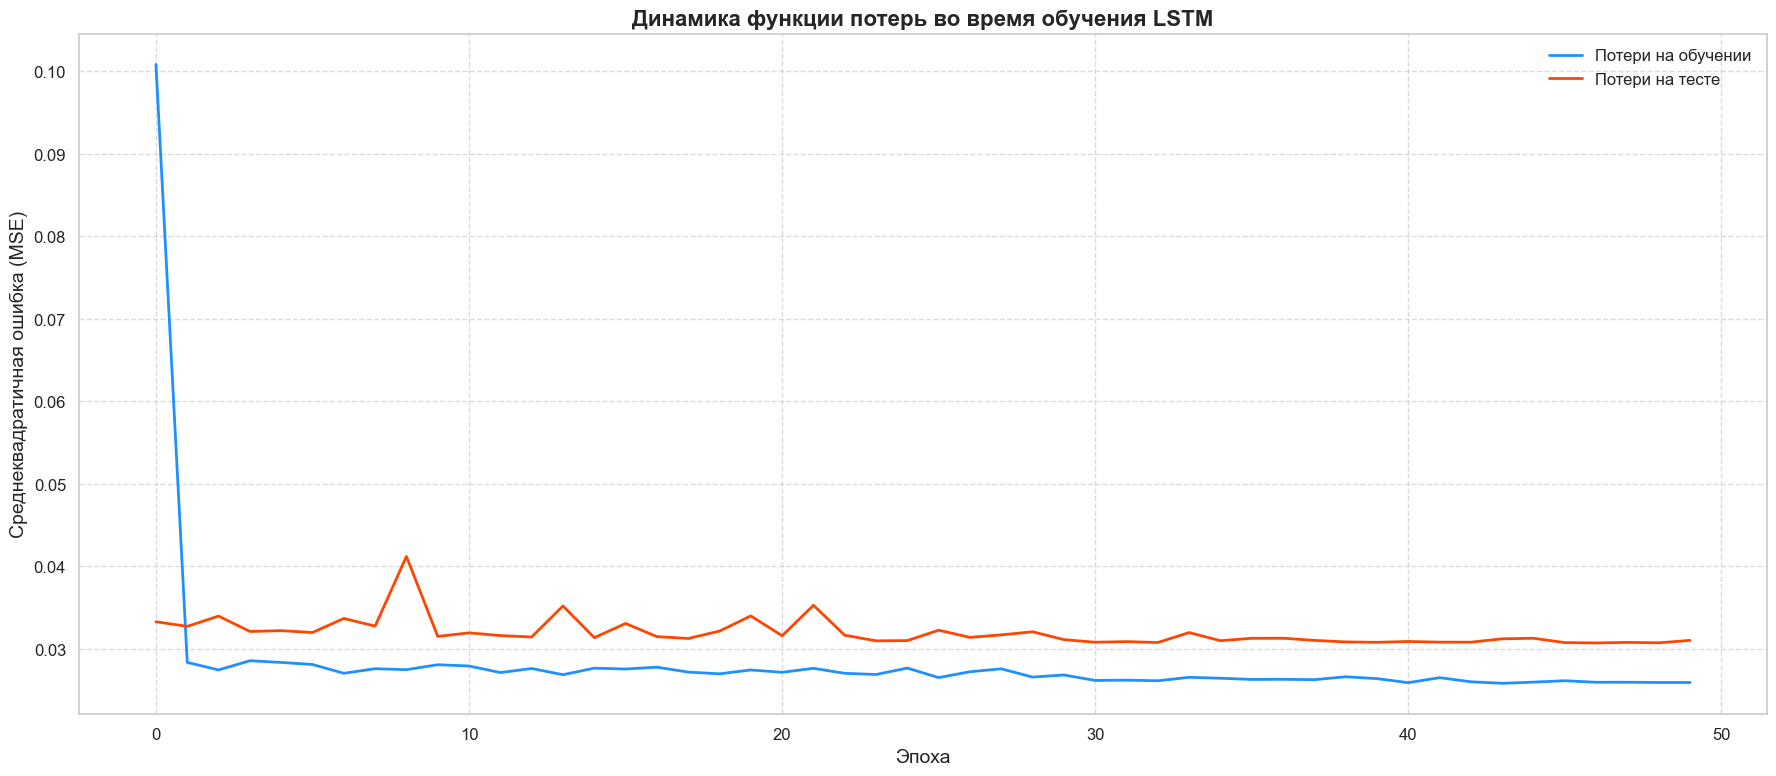

In [7]:
# 5. Обучение модели
# -----------------

# Параметры обучения
num_epochs = 50
train_losses = []
test_losses = []

# Переводим модель в режим обучения
model.train()

# Обучение модели
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Перемещаем батч на нужное устройство
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Преобразование формы входных данных для LSTM [batch_size, seq_length, input_size]
        X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)

        # Прямой проход
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Вычисление средней потери на обучении за эпоху
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Оценка на тестовой выборке
    model.eval() # Переводим модель в режим оценки
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Шаг планировщика (опционально)
    scheduler.step(avg_test_loss)

    # Переводим модель обратно в режим обучения для следующей эпохи
    model.train()

    # Вывод информации о процессе обучения (каждые 5 эпох)
    if (epoch + 1) % 5 == 0:
        print(f'Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {avg_train_loss:.4f}, Потери на тесте: {avg_test_loss:.4f}')

# Визуализация процесса обучения
plt.figure(figsize=(18, 8))
plt.plot(range(num_epochs), train_losses, label='Потери на обучении', color='dodgerblue', linewidth=2)
plt.plot(range(num_epochs), test_losses, label='Потери на тесте', color='orangered', linewidth=2)
plt.title('Динамика функции потерь во время обучения LSTM', fontsize=16, fontweight='bold')
plt.xlabel('Эпоха', fontsize=14)
plt.ylabel('Среднеквадратичная ошибка (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Количество обнаруженных аномалий (по MSE): 21
Количество обнаруженных аномалий (почти нулевая активность): 31


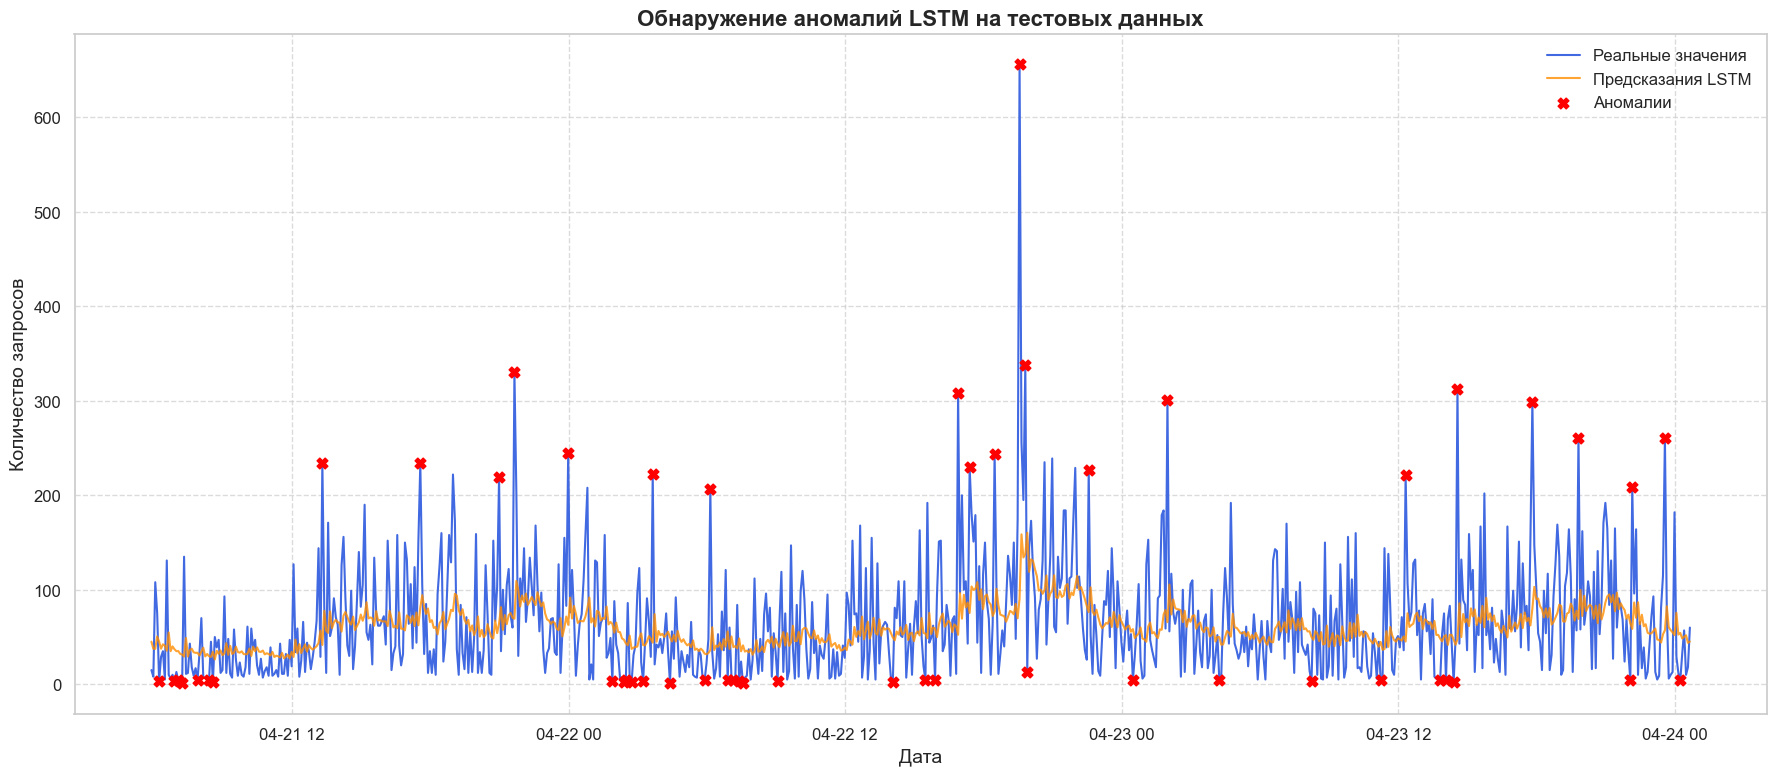


Общее количество уникальных аномалий: 52 из 802 точек (6.48%)


In [8]:
# 6. Тестирование модели и обнаружение аномалий (Обновлено)
# ----------------------------------------------------------

# Переводим модель в режим оценки
model.eval()
predictions = []
actuals_scaled = []

# Получаем предсказания для тестовой выборки
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.view(X_batch.shape[0], seq_length, 1)
        outputs = model(X_batch)
        # Собираем предсказания и реальные значения (масштабированные)
        predictions.extend(outputs.cpu().detach().numpy())
        actuals_scaled.extend(y_batch.cpu().detach().numpy())

# Преобразование в numpy массивы
predictions_scaled = np.array(predictions)
actuals_scaled = np.array(actuals_scaled)

# Вычисление ошибки предсказания (MSE) для каждой точки
mse_per_point = (predictions_scaled - actuals_scaled) ** 2

# 1. Обнаружение аномалий по порогу MSE
# Используем MSE на *обучающей* выборке для расчета порога (более стабильно)
train_mse = []
with torch.no_grad():
  for X_batch_train, y_batch_train in train_loader:
    X_batch_train = X_batch_train.to(device)
    X_batch_train = X_batch_train.view(X_batch_train.shape[0], seq_length, 1)
    outputs_train = model(X_batch_train)
    mse_train = ((outputs_train - y_batch_train.to(device)) ** 2).cpu().numpy()
    train_mse.extend(mse_train)
train_mse = np.array(train_mse)

threshold_mse = np.mean(train_mse) + 3 * np.std(train_mse)
anomalies_mse = mse_per_point > threshold_mse
num_anomalies_mse = np.sum(anomalies_mse)
print(f'Количество обнаруженных аномалий (по MSE): {num_anomalies_mse}')

# 2. Обнаружение аномалий по почти нулевой активности
# Определяем порог низкой активности (например, 5% перцентиль на обучающей выборке)
low_activity_threshold_scaled = np.percentile(y_train, 5) # Используем масштабированные данные
low_activity_threshold_original = scaler.inverse_transform([[low_activity_threshold_scaled]])[0,0]
# Считаем аномалией, если реальное значение НИЖЕ порога НИЗКОЙ активности,
# а предсказанное значение ВЫШЕ этого порога (модель не ожидала такой низкой активности)
anomalies_low_activity = (actuals_scaled < low_activity_threshold_scaled) & (predictions_scaled > low_activity_threshold_scaled)
num_anomalies_low = np.sum(anomalies_low_activity)
print(f'Количество обнаруженных аномалий (почти нулевая активность): {num_anomalies_low}')

# Объединяем аномалии, найденные обоими методами
# Обратите внимание, что is_anomaly будет True, если хотя бы одно из условий выполнено
# .flatten() нужен, так как anomalies_low_activity может быть [N, 1], а anomalies_mse [N,]
is_anomaly = anomalies_mse.flatten() | anomalies_low_activity.flatten()
num_anomalies_total = np.sum(is_anomaly)

# Возвращаем значения в исходный масштаб для графика и анализа
predictions_rescaled = scaler.inverse_transform(predictions_scaled).flatten()
actuals_rescaled = scaler.inverse_transform(actuals_scaled).flatten()

# Получение временного ряда для тестовой выборки
# Индексы для тестовой выборки начинаются после train_size + seq_length
# и идут до конца, минус 1, так как y_test смещен на 1
test_start_index = train_size + seq_length
# Корректный срез индекса для тестовых данных
test_indices = df.index[test_start_index : test_start_index + len(X_test)]

# Создание DataFrame с результатами
results_df = pd.DataFrame({
    'timestamp': test_indices,
    'actual': actuals_rescaled,
    'prediction': predictions_rescaled,
    'mse': mse_per_point.flatten(),
    'is_anomaly_mse': anomalies_mse.flatten(),
    'is_anomaly_low': anomalies_low_activity.flatten(),
    'is_anomaly': is_anomaly
})

# Построение графика с аномалиями
plt.figure(figsize=(18, 8))
plt.plot(results_df['timestamp'], results_df['actual'], label='Реальные значения', color='royalblue', linewidth=1.5, zorder=1)
plt.plot(results_df['timestamp'], results_df['prediction'], label='Предсказания LSTM', color='darkorange', linewidth=1.5, alpha=0.8, zorder=2)

# Отмечаем аномалии
anomalies_plot = results_df[results_df['is_anomaly']]
plt.scatter(anomalies_plot['timestamp'], anomalies_plot['actual'], color='red', label='Аномалии', s=60, zorder=3, marker='X')

plt.title('Обнаружение аномалий LSTM на тестовых данных', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество запросов', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print(f'\nОбщее количество уникальных аномалий: {num_anomalies_total} из {len(results_df)} точек ({num_anomalies_total/len(results_df)*100:.2f}%)')


Топ-10 аномалий по MSE:
              timestamp  actual  prediction       mse
452 2014-04-22 19:34:00   656.0   90.624626  2.980239
680 2014-04-23 14:34:00   313.0   47.788601  0.655785
189 2014-04-21 21:39:00   330.0   69.356827  0.633388
420 2014-04-22 16:54:00   308.0   52.356209  0.609323
529 2014-04-23 01:59:00   301.0   65.717422  0.516127
719 2014-04-23 17:49:00   299.0   80.134224  0.446615
788 2014-04-23 23:34:00   261.0   57.105259  0.387605
455 2014-04-22 19:49:00   338.0  137.774353  0.373781
89  2014-04-21 13:19:00   234.0   41.566086  0.345256
743 2014-04-23 19:49:00   261.0   69.225418  0.342894

Аномалии с низкой активностью:
              timestamp    actual  prediction       mse  is_anomaly_mse  \
4   2014-04-21 06:14:00  2.999995   45.089111  0.016516           False   
12  2014-04-21 06:54:00  2.999995   37.065060  0.010819           False   
14  2014-04-21 07:04:00  3.999992   35.102215  0.009019           False   
16  2014-04-21 07:14:00  1.000000   31.510067  0.

C:\Users\ivglu\AppData\Local\Temp\ipykernel_24832\2504153369.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=anomaly_data, palette='coolwarm')


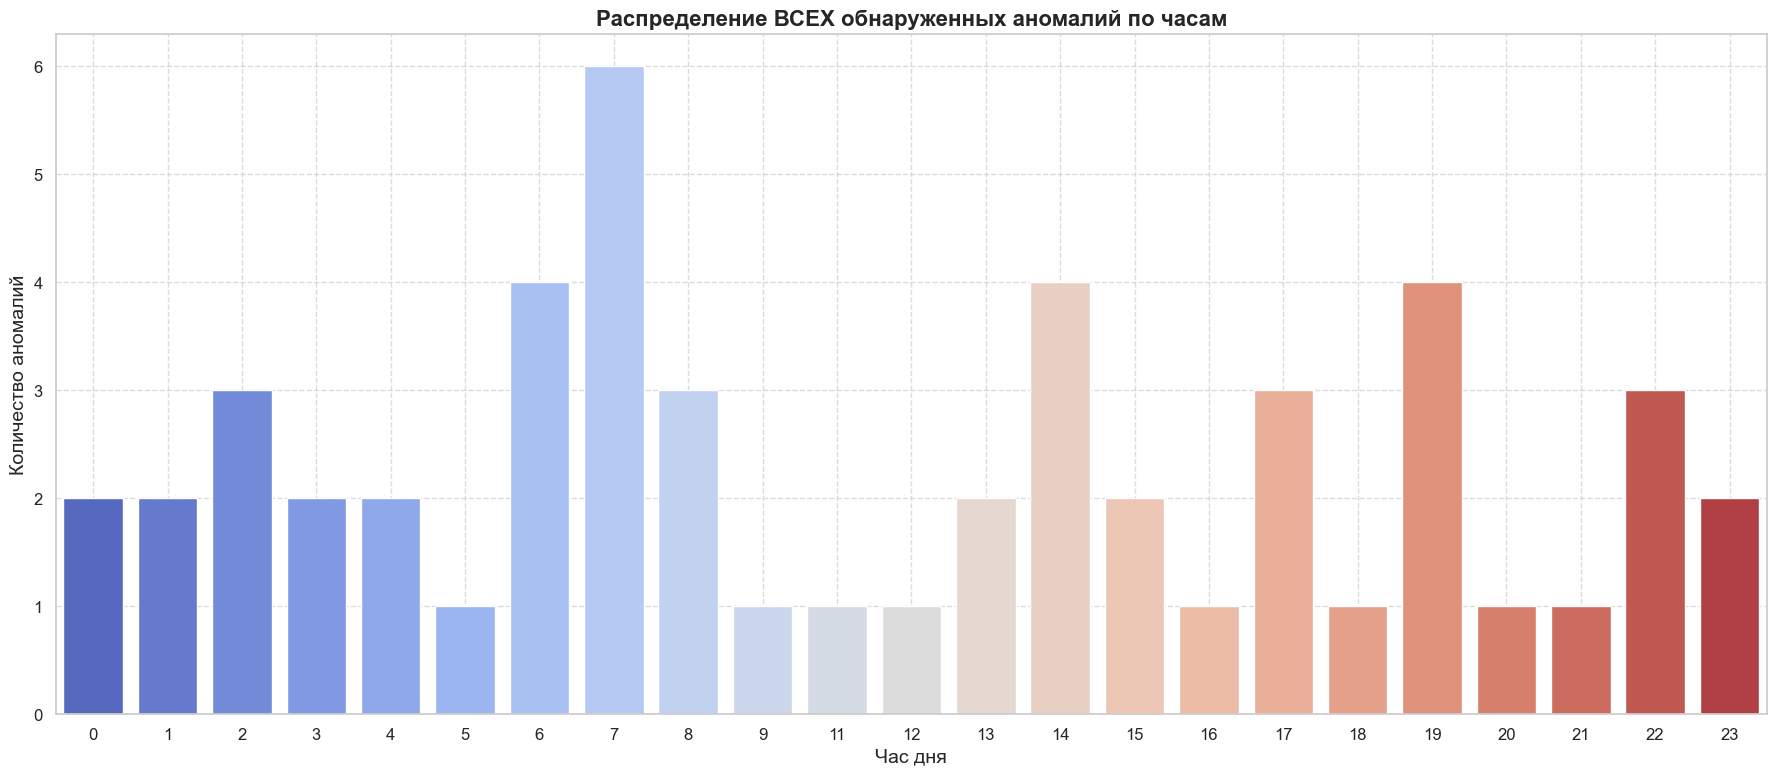

C:\Users\ivglu\AppData\Local\Temp\ipykernel_24832\2504153369.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dayofweek', data=anomaly_data, order=range(7), palette='rocket')


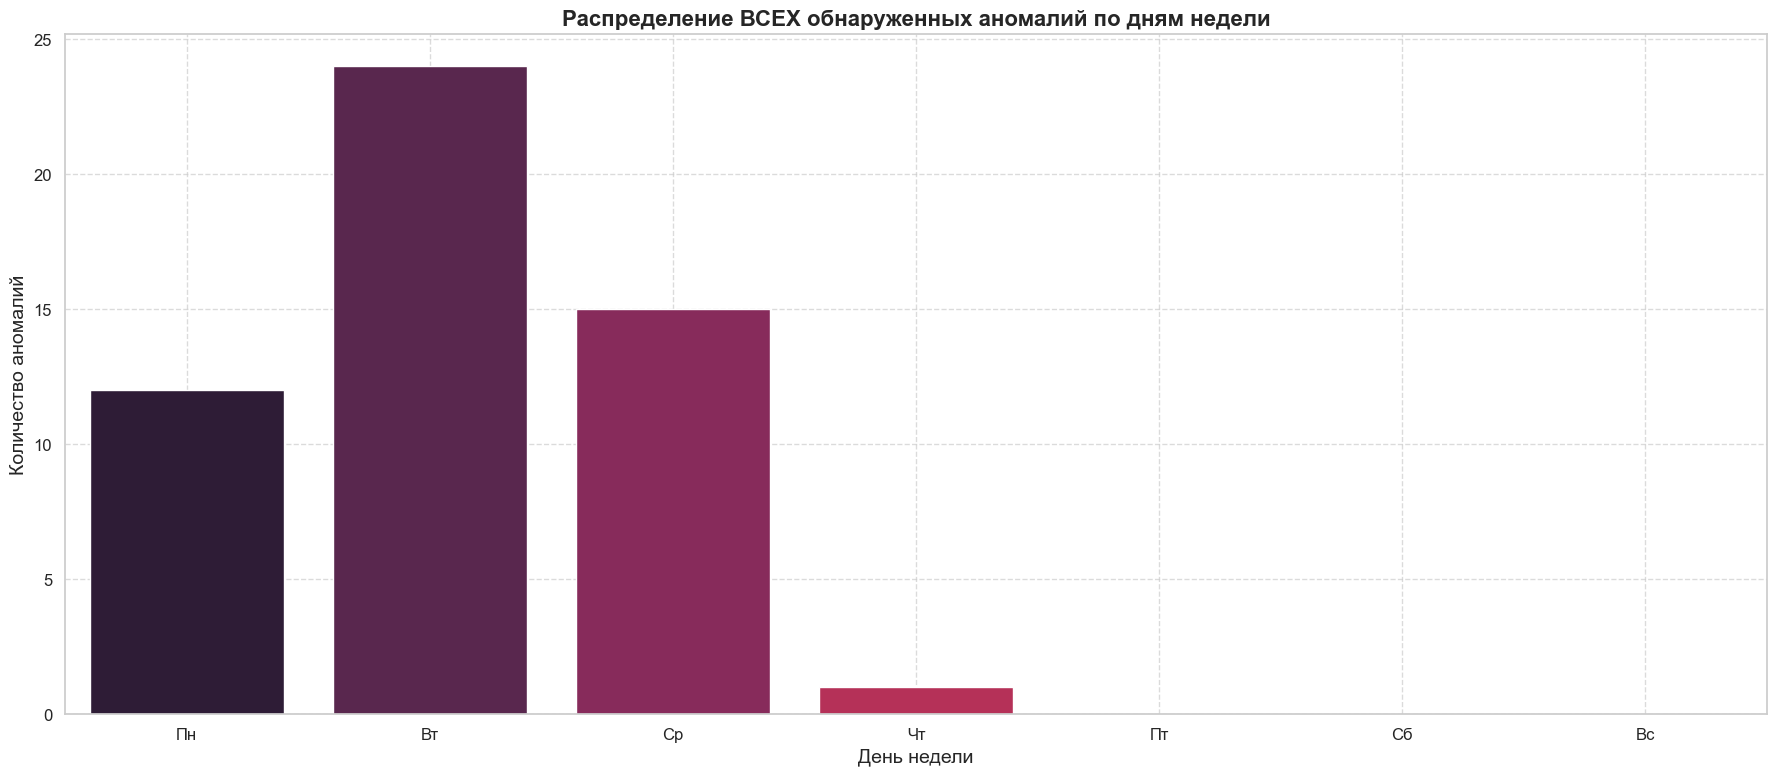

In [9]:
# 7. Анализ аномалий (Обновлено)
# ----------------------------

# Сортировка по степени аномальности (MSE)
results_sorted_mse = results_df.sort_values(by='mse', ascending=False)

# Вывод топ-10 аномалий по MSE
print("\nТоп-10 аномалий по MSE:")
print(results_sorted_mse.head(10)[['timestamp', 'actual', 'prediction', 'mse']])

# Вывод аномалий с низкой активностью
print("\nАномалии с низкой активностью:")
print(results_df[results_df['is_anomaly_low']])

# Характеристики всех аномалий
anomaly_data = results_df[results_df['is_anomaly']]

# Суточное распределение аномалий
anomaly_data = anomaly_data.copy() # Создаем копию для избежания SettingWithCopyWarning
anomaly_data['hour'] = anomaly_data['timestamp'].dt.hour
anomaly_data['dayofweek'] = anomaly_data['timestamp'].dt.dayofweek

plt.figure(figsize=(18, 8))
sns.countplot(x='hour', data=anomaly_data, palette='coolwarm')
plt.title('Распределение ВСЕХ обнаруженных аномалий по часам', fontsize=16, fontweight='bold')
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество аномалий', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 8))
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
sns.countplot(x='dayofweek', data=anomaly_data, order=range(7), palette='rocket')
plt.title('Распределение ВСЕХ обнаруженных аномалий по дням недели', fontsize=16, fontweight='bold')
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество аномалий', fontsize=14)
plt.xticks(ticks=range(7), labels=day_names, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# 8. Автоматизация обнаружения аномалий на новых данных (Обновлено)
# ---------------------------------------------------------------

# Функция для обнаружения аномалий в новом временном ряду
def detect_anomalies(model, new_data_df, scaler, seq_length, threshold_mse, threshold_low_activity_scaled):
    """
    Обнаружение аномалий в новых данных (DataFrame) с помощью обученной модели,
    используя два критерия: порог MSE и порог низкой активности.

    Parameters:
    -----------
    model : PyTorch модель
        Обученная модель для предсказания.
    new_data_df : pandas.DataFrame
        Новые данные с обязательным столбцом 'value' и DatetimeIndex.
    scaler : MinMaxScaler
        Обученный скейлер для нормализации данных.
    seq_length : int
        Длина последовательности для предсказания.
    threshold_mse : float
        Порог MSE для определения аномалий.
    threshold_low_activity_scaled : float
        Масштабированный порог низкой активности.

    Returns:
    --------
    pandas.DataFrame
        DataFrame с результатами анализа и обнаруженными аномалиями.
    """
    if 'value' not in new_data_df.columns:
        raise ValueError("DataFrame должен содержать столбец 'value'")
    if not isinstance(new_data_df.index, pd.DatetimeIndex):
        raise ValueError("Индекс DataFrame должен быть DatetimeIndex")

    # Убедимся, что данных достаточно для создания хотя бы одной последовательности
    if len(new_data_df) <= seq_length:
        print(f"Недостаточно данных для создания последовательности (нужно > {seq_length}, получено {len(new_data_df)}). Аномалии не обнаружены.")
        return pd.DataFrame(columns=['timestamp', 'actual', 'prediction', 'mse', 'is_anomaly_mse', 'is_anomaly_low', 'is_anomaly'])

    # Масштабирование данных
    scaled_data = scaler.transform(new_data_df[['value']])

    # Создание последовательностей
    X = []
    actual_indices = []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        actual_indices.append(i + seq_length)
    X = np.array(X)

    # Преобразование в тензор и перемещение на устройство
    X_tensor = torch.FloatTensor(X).to(device)
    X_tensor = X_tensor.view(X_tensor.shape[0], seq_length, 1)

    # Предсказание
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_tensor).cpu().numpy()

    # Реальные значения (масштабированные)
    actuals_scaled = scaled_data[actual_indices].reshape(-1, 1)

    # Вычисление ошибки MSE для каждой точки
    mse_per_point = (predictions_scaled - actuals_scaled) ** 2

    # Определение аномалий по порогу MSE
    anomalies_mse = mse_per_point > threshold_mse

    # Определение аномалий по низкой активности
    anomalies_low_activity = (actuals_scaled < threshold_low_activity_scaled) & (predictions_scaled > threshold_low_activity_scaled)

    # Объединение аномалий
    is_anomaly = anomalies_mse.flatten() | anomalies_low_activity.flatten()

    # Возврат к исходному масштабу
    predictions_rescaled = scaler.inverse_transform(predictions_scaled).flatten()
    actuals_rescaled = scaler.inverse_transform(actuals_scaled).flatten()

    # Временные метки для результатов
    result_timestamps = new_data_df.index[actual_indices]

    # Создание DataFrame с результатами
    results = pd.DataFrame({
        'timestamp': result_timestamps,
        'actual': actuals_rescaled,
        'prediction': predictions_rescaled,
        'mse': mse_per_point.flatten(),
        'is_anomaly_mse': anomalies_mse.flatten(),
        'is_anomaly_low': anomalies_low_activity.flatten(),
        'is_anomaly': is_anomaly
    })

    return results

# --- Пример использования функции detect_anomalies ---
# # Загрузка или симуляция новых данных (new_df)
# # Убедитесь, что new_df имеет столбец 'value' и DatetimeIndex
# # new_df = pd.read_csv('new_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# # Пример с последними 100 точками из тестового набора как "новые данные"
# last_100_index_start = len(df) - 100
# new_df_example = df.iloc[last_100_index_start:][['value']].copy()
#
# # Обнаружение аномалий
# # Важно: используем пороги, рассчитанные на обучающей выборке
# new_anomalies_df = detect_anomalies(model, new_df_example, scaler, seq_length, threshold_mse, low_activity_threshold_scaled)
#
# # Вывод новых аномалий
# print("\nОбнаруженные аномалии в новых данных:")
# print(new_anomalies_df[new_anomalies_df['is_anomaly']])
#
# # Визуализация новых данных с аномалиями (если они есть)
# if not new_anomalies_df.empty:
#     plt.figure(figsize=(18, 8))
#     plt.plot(new_anomalies_df['timestamp'], new_anomalies_df['actual'], label='Реальные значения', color='royalblue', linewidth=1.5)
#     plt.plot(new_anomalies_df['timestamp'], new_anomalies_df['prediction'], label='Предсказания LSTM', color='darkorange', alpha=0.8, linewidth=1.5)
#     new_anomalies_points = new_anomalies_df[new_anomalies_df['is_anomaly']]
#     plt.scatter(new_anomalies_points['timestamp'], new_anomalies_points['actual'], color='red', label='Аномалии', s=60, marker='X')
#     plt.title('Обнаружение аномалий в новых данных', fontsize=16, fontweight='bold')
#     plt.xlabel('Дата', fontsize=14)
#     plt.ylabel('Количество запросов', fontsize=14)
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()
# else:
#     print("\nАномалии в новых данных не обнаружены.")

In [11]:
# 9. Выводы(Обновлено)
# -------------------------------------

# Сводка результатов
print("\n=== Сводка результатов анализа аномалий ===")
print(f"Всего точек данных для оценки: {len(results_df)}")
print(f"Обнаружено аномалий: {num_anomalies_total} ({num_anomalies_total/len(results_df)*100:.2f}%)")
print(f"  - по MSE: {num_anomalies_mse}")
print(f"  - по низкой активности: {num_anomalies_low}")
print(f"Средняя ошибка предсказания (MSE) на тесте: {np.mean(mse_per_point):.6f}")
print(f"Порог MSE для аномалий: {threshold_mse:.6f}")
print(f"Порог низкой активности (исходный масштаб): {low_activity_threshold_original:.6f}")



# Сохранение модели для будущего использования
model_save_path = 'lstm_anomaly_detection_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\nМодель сохранена в '{model_save_path}'")


=== Сводка результатов анализа аномалий ===
Всего точек данных для оценки: 802
Обнаружено аномалий: 52 (6.48%)
  - по MSE: 21
  - по низкой активности: 31
Средняя ошибка предсказания (MSE) на тесте: 0.032035
Порог MSE для аномалий: 0.201712
Порог низкой активности (исходный масштаб): 5.000000

Модель сохранена в 'lstm_anomaly_detection_model.pth'
